Epoch=0, 	 loss=1.723e+01, 	 loss_IC=4.830e-01, 	 loss_d=1.674e+01, 	 loss_e1=6.388e-02, 	 loss_e2=1.276e-01, 	 loss_e3=8.706e+00
Total running time: 9.7882 seconds
Epoch=1000, 	 loss=8.553e-04, 	 loss_IC=3.792e-07, 	 loss_d=8.549e-04, 	 loss_e1=6.332e-02, 	 loss_e2=1.824e-01, 	 loss_e3=4.369e-02
Total running time: 41.0619 seconds
Epoch=2000, 	 loss=2.060e-04, 	 loss_IC=3.937e-09, 	 loss_d=2.060e-04, 	 loss_e1=6.307e-02, 	 loss_e2=1.823e-01, 	 loss_e3=4.345e-02
Total running time: 72.6934 seconds
Epoch=3000, 	 loss=9.371e-05, 	 loss_IC=2.847e-08, 	 loss_d=9.368e-05, 	 loss_e1=6.312e-02, 	 loss_e2=1.822e-01, 	 loss_e3=4.340e-02
Total running time: 106.4883 seconds
Epoch=4000, 	 loss=4.475e-05, 	 loss_IC=1.081e-08, 	 loss_d=4.474e-05, 	 loss_e1=6.321e-02, 	 loss_e2=1.822e-01, 	 loss_e3=4.335e-02
Total running time: 142.9173 seconds
Epoch=5000, 	 loss=2.545e-05, 	 loss_IC=2.021e-09, 	 loss_d=2.545e-05, 	 loss_e1=6.332e-02, 	 loss_e2=1.822e-01, 	 loss_e3=4.332e-02
Total running time: 179.

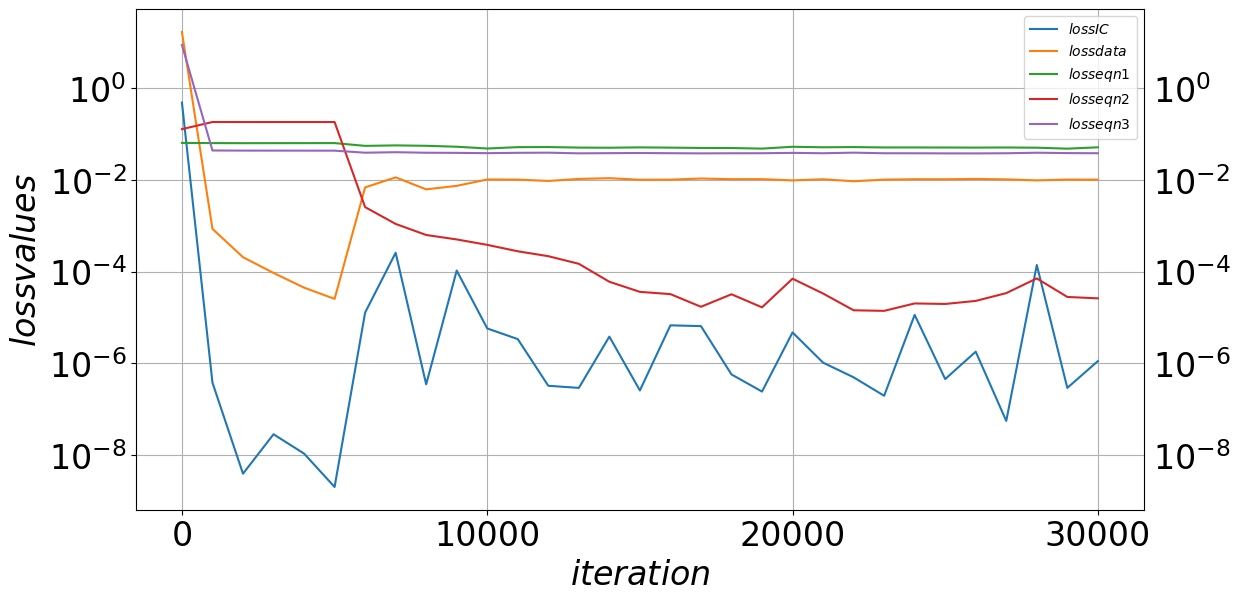

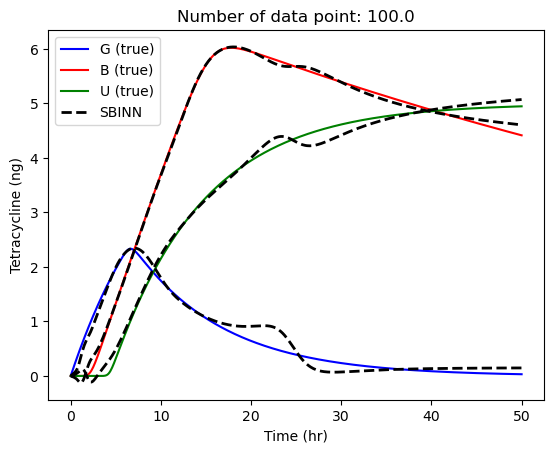

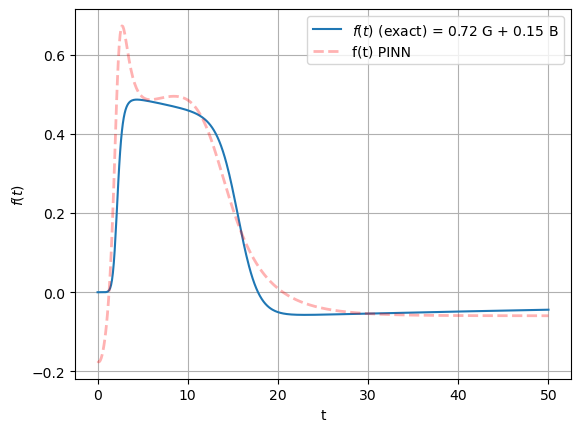

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import time
import pandas as pd
import jaxopt
from scipy.integrate import odeint


def drug_model(
    t,
    k1 = 0.5,
    k2 = 0.5,
    k3 = 0.5,
    gamma1 = 0.1 ,
    gamma2 = 0.01 ,
    gamma3 = 0.1 ,
    c = 1 ,
    n = 9, 
):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]

        return [
            ((c**n)/((c**n)+ (U**n))  *k1) - gamma1*G,
            ((G**n)/((c**n)+ (G**n))  *k2) - gamma2*B,
            ((B**n)/((c**n)+ (B**n))  *k1) - gamma3*U,
            ]

    y0 = [0, 0, 0]
    return odeint(func, y0, t)


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

sample_rate = 5
dp=  500/sample_rate
t_data = t_dense[::sample_rate,0:1]
G_data = y_dense[::sample_rate,0:1]
B_data = y_dense[::sample_rate,1:2]
U_data = y_dense[::sample_rate,2:3]

data = jnp.concatenate([G_data, B_data, U_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([G_data[0:1,:], B_data[0:1,:], U_data[0:1,:]], axis=1)




tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params


def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  # X = X**2
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



def ODE_loss(t, y1, y2, y3, f_t):
    k1 = 0.5
    k2 = 0.5
    k3 = 0.5
    gamma1 = 0.1 
    gamma2 = 0.01 
    gamma3 = 0.1 
    c = 1 
    n = 9

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    ode1 = y1_t(t) -  (((c**n)/((c**n)+ (y1(t)**n))  *k1) - gamma1*y1(t))
    ode2 = y2_t(t) - f_t(t)
    ode3 = y3_t(t) - (((y2(t)**n)/((c**n)+ (y2(t)**n))  *k1) - gamma3*y1(t))

    return ode1, ode2, ode3




#collocation points
N_c = 500

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_extra,l1 ,l2 ,l3 , t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, y1_func, y2_func, y3_func, f_t)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2
    loss_y3 = l3*loss_y3

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3


def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    return loss_total


def loss_fun_total_lbfgs(params_total, t_i, t_d, t_c, data_IC, data, loss_weight):

    params, params_extra, l1,l2, l3 = params_total[0], params_total[1], params_total[2], params_total[3], params_total[4]

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1 ,l2, l3, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    print(f"Loss: {loss_total}")

    return loss_total




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)

  updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)

  return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-4)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)

lambda_1 = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))

opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)

#@title **two step training**


start_time = time.time()
epochs_phase1 = 5000
epochs_phase2 = 25000

loss_weight_phase1 = [1, 1, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,params,opt_state_extra,\
    params_extra, params_l1, params_l2,\
    params_l3, opt_state_l1,opt_state_l2, opt_state_l3 = update(opt_state, opt_state_extra, params, params_extra,\
                                                             lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                                              opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      print(f'Epoch={ep}, \t loss={loss_val:.3e}, \t loss_IC={loss_val_individual[0]:.3e}, \t loss_d={loss_val_individual[1]:.3e}, \t loss_e1={loss_val_individual[2]:.3e}, \t loss_e2={loss_val_individual[3]:.3e}, \t loss_e3={loss_val_individual[4]:.3e}')
      end_time = time.time()

      running_time = end_time - start_time
      print(f"Total running time: {running_time:.4f} seconds")






print("L-BFGS optimizer begins")

loss_weight = [1, 1, 1, 1, 1]

params_total = []
params_total.append(params)
params_total.append(params_extra)
params_total.append(params_l1)
params_total.append(params_l2)
params_total.append(params_l3)

start_time = time.time()

l_fun = lambda p_l: loss_fun_total_lbfgs(p_l, t_i, t_data, t_c, IC, data, loss_weight)

optimizer_lbfgs = jaxopt.LBFGS(fun=l_fun, history_size=100,  verbose=True, maxiter=100)
sol = optimizer_lbfgs.run(params_total)
params_total = sol.params

end_time = time.time()

running_time += end_time - start_time
print(f"Total running time: {running_time:.2f} seconds")

params = params_total[0]
params_extra = params_total[1]
np.savez(f'./params_{dp}.npz', *params)
np.savez(f'./params_extra_{dp}.npz', *params_extra)

k1 = 0.5,
k2 = 0.5,
k3 = 0.5,
gamma1 = 0.1 ,
gamma2 = 0.01 ,
gamma3 = 0.1 ,
c = 1 ,
n = 9,

SAVE_FIG = True
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig('./History_loss.png', dpi=300)




# pred = fwd(params,t_test)
pred = fwd(params,t_dense)
plt.figure()
plt.plot(t_dense, y_dense[:, 0:1],'-b',label='G (true)')
plt.plot(t_dense, y_dense[:, 1:2],'-r',label='B (true)')
plt.plot(t_dense, y_dense[:, 2:3],'-g',label='U (true)')

plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.plot(t_dense,pred[:,1],'--k',linewidth=2)
plt.plot(t_dense,pred[:,2],'--k',linewidth=2)
plt.title(f'Number of data point: {dp}')
plt.xlabel('Time (hr)')
plt.ylabel('Tetracycline (ng)')
plt.legend()
if SAVE_FIG:
    plt.savefig('./Pred.png', dpi=300)
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

f_t_analytical = (np.power(y_dense[:, 0],n))/((c**n)+ np.power(y_dense[:, 0],n)) *k2 - gamma2*y_dense[:, 1]  # 2nd equation
f_t_neural = fwd_extra(params_extra, t_dense)[:, 0]

G_pred = pred[:,0:1]
B_pred = pred[:,1:2]
U_pred = pred[:,2:3]
df_f = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred),"U": np.ravel(U_pred) ,"ft": np.ravel(f_t_neural) })
df_f.to_csv("./pred_100.csv", index=False)

plt.figure()
plt.plot(t_dense, f_t_analytical, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
plt.plot(t_dense, f_t_neural,'--r',linewidth=2, label='f(t) PINN', alpha=0.3)
plt.grid()
plt.xlabel('t')
plt.ylabel('$f(t)$')
plt.legend()
if SAVE_FIG:
    plt.savefig('./ft.png', dpi=300)




Epoch=0, 	 loss=1.716e+01, 	 loss_IC=4.830e-01, 	 loss_d=1.667e+01, 	 loss_e1=6.388e-02, 	 loss_e2=1.276e-01, 	 loss_e3=8.675e+00
Total running time: 8.9731 seconds
Epoch=1000, 	 loss=8.086e-04, 	 loss_IC=3.520e-07, 	 loss_d=8.082e-04, 	 loss_e1=6.327e-02, 	 loss_e2=1.824e-01, 	 loss_e3=4.363e-02
Total running time: 39.7084 seconds
Epoch=2000, 	 loss=2.065e-04, 	 loss_IC=1.707e-09, 	 loss_d=2.065e-04, 	 loss_e1=6.308e-02, 	 loss_e2=1.822e-01, 	 loss_e3=4.344e-02
Total running time: 68.7532 seconds
Epoch=3000, 	 loss=9.164e-05, 	 loss_IC=1.752e-06, 	 loss_d=8.989e-05, 	 loss_e1=6.311e-02, 	 loss_e2=1.823e-01, 	 loss_e3=4.341e-02
Total running time: 96.1196 seconds
Epoch=4000, 	 loss=4.135e-05, 	 loss_IC=5.912e-09, 	 loss_d=4.135e-05, 	 loss_e1=6.321e-02, 	 loss_e2=1.821e-01, 	 loss_e3=4.334e-02
Total running time: 133.0440 seconds
Epoch=5000, 	 loss=2.375e-05, 	 loss_IC=4.405e-09, 	 loss_d=2.374e-05, 	 loss_e1=6.329e-02, 	 loss_e2=1.821e-01, 	 loss_e3=4.331e-02
Total running time: 178.9

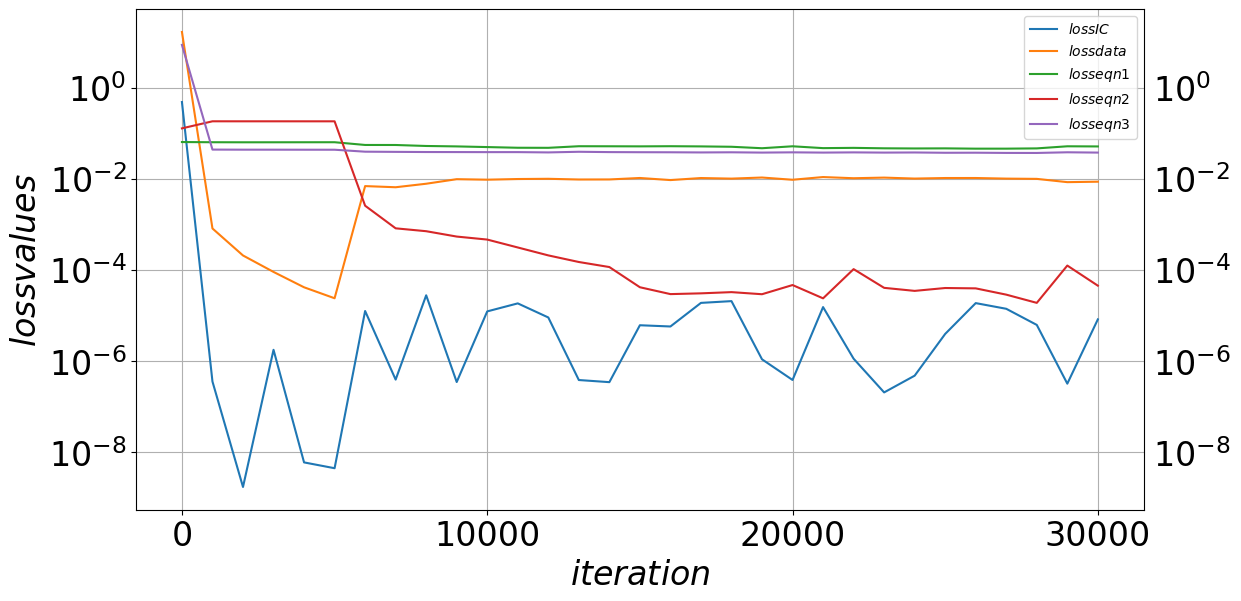

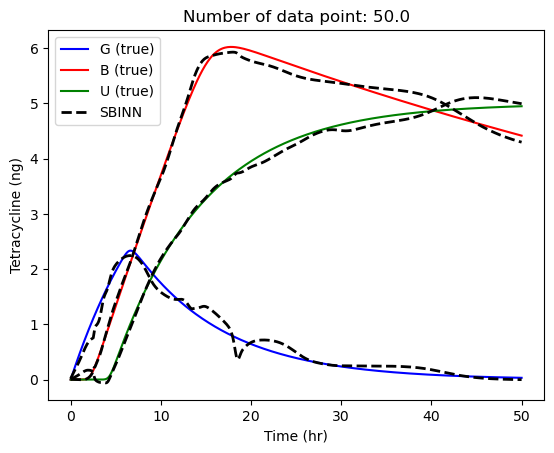

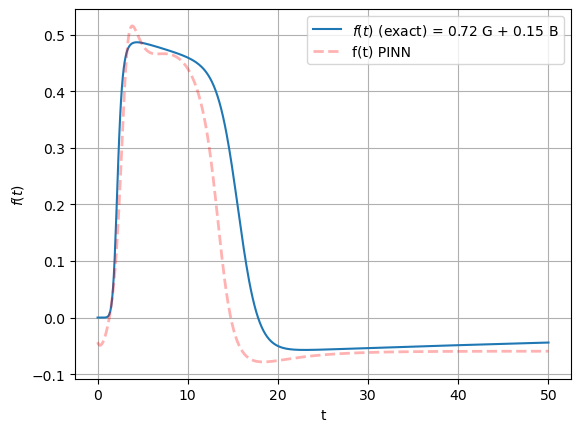

In [13]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import time
import pandas as pd
import jaxopt
from scipy.integrate import odeint


def drug_model(
    t,
    k1 = 0.5,
    k2 = 0.5,
    k3 = 0.5,
    gamma1 = 0.1 ,
    gamma2 = 0.01 ,
    gamma3 = 0.1 ,
    c = 1 ,
    n = 9, 
):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]

        return [
            ((c**n)/((c**n)+ (U**n))  *k1) - gamma1*G,
            ((G**n)/((c**n)+ (G**n))  *k2) - gamma2*B,
            ((B**n)/((c**n)+ (B**n))  *k1) - gamma3*U,
            ]

    y0 = [0, 0, 0]
    return odeint(func, y0, t)


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

sample_rate = 10
dp=  500/sample_rate
t_data = t_dense[::sample_rate,0:1]
G_data = y_dense[::sample_rate,0:1]
B_data = y_dense[::sample_rate,1:2]
U_data = y_dense[::sample_rate,2:3]

data = jnp.concatenate([G_data, B_data, U_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([G_data[0:1,:], B_data[0:1,:], U_data[0:1,:]], axis=1)




tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params


def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  # X = X**2
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



def ODE_loss(t, y1, y2, y3, f_t):
    k1 = 0.5
    k2 = 0.5
    k3 = 0.5
    gamma1 = 0.1 
    gamma2 = 0.01 
    gamma3 = 0.1 
    c = 1 
    n = 9

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    ode1 = y1_t(t) -  (((c**n)/((c**n)+ (y1(t)**n))  *k1) - gamma1*y1(t))
    ode2 = y2_t(t) - f_t(t)
    ode3 = y3_t(t) - (((y2(t)**n)/((c**n)+ (y2(t)**n))  *k1) - gamma3*y1(t))

    return ode1, ode2, ode3




#collocation points
N_c = 500

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_extra,l1 ,l2 ,l3 , t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, y1_func, y2_func, y3_func, f_t)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2
    loss_y3 = l3*loss_y3

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3


def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    return loss_total


def loss_fun_total_lbfgs(params_total, t_i, t_d, t_c, data_IC, data, loss_weight):

    params, params_extra, l1,l2, l3 = params_total[0], params_total[1], params_total[2], params_total[3], params_total[4]

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1 ,l2, l3, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    print(f"Loss: {loss_total}")

    return loss_total




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)

  updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)

  return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-4)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)

lambda_1 = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))

opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)

#@title **two step training**


start_time = time.time()
epochs_phase1 = 5000
epochs_phase2 = 25000

loss_weight_phase1 = [1, 1, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,params,opt_state_extra,\
    params_extra, params_l1, params_l2,\
    params_l3, opt_state_l1,opt_state_l2, opt_state_l3 = update(opt_state, opt_state_extra, params, params_extra,\
                                                             lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                                              opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      print(f'Epoch={ep}, \t loss={loss_val:.3e}, \t loss_IC={loss_val_individual[0]:.3e}, \t loss_d={loss_val_individual[1]:.3e}, \t loss_e1={loss_val_individual[2]:.3e}, \t loss_e2={loss_val_individual[3]:.3e}, \t loss_e3={loss_val_individual[4]:.3e}')
      end_time = time.time()

      running_time = end_time - start_time
      print(f"Total running time: {running_time:.4f} seconds")






print("L-BFGS optimizer begins")

loss_weight = [1, 1, 1, 1, 1]

params_total = []
params_total.append(params)
params_total.append(params_extra)
params_total.append(params_l1)
params_total.append(params_l2)
params_total.append(params_l3)

start_time = time.time()

l_fun = lambda p_l: loss_fun_total_lbfgs(p_l, t_i, t_data, t_c, IC, data, loss_weight)

optimizer_lbfgs = jaxopt.LBFGS(fun=l_fun, history_size=100,  verbose=True, maxiter=100)
sol = optimizer_lbfgs.run(params_total)
params_total = sol.params

end_time = time.time()

running_time += end_time - start_time
print(f"Total running time: {running_time:.2f} seconds")

params = params_total[0]
params_extra = params_total[1]
np.savez(f'./params_{dp}.npz', *params)
np.savez(f'./params_extra_{dp}.npz', *params_extra)

k1 = 0.5,
k2 = 0.5,
k3 = 0.5,
gamma1 = 0.1 ,
gamma2 = 0.01 ,
gamma3 = 0.1 ,
c = 1 ,
n = 9,

SAVE_FIG = True
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig('./History_loss.png', dpi=300)




# pred = fwd(params,t_test)
pred = fwd(params,t_dense)
plt.figure()
plt.plot(t_dense, y_dense[:, 0:1],'-b',label='G (true)')
plt.plot(t_dense, y_dense[:, 1:2],'-r',label='B (true)')
plt.plot(t_dense, y_dense[:, 2:3],'-g',label='U (true)')

plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.plot(t_dense,pred[:,1],'--k',linewidth=2)
plt.plot(t_dense,pred[:,2],'--k',linewidth=2)
plt.title(f'Number of data point: {dp}')
plt.xlabel('Time (hr)')
plt.ylabel('Tetracycline (ng)')
plt.legend()
if SAVE_FIG:
    plt.savefig('./Pred.png', dpi=300)
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

f_t_analytical = (np.power(y_dense[:, 0],n))/((c**n)+ np.power(y_dense[:, 0],n)) *k2 - gamma2*y_dense[:, 1]  # 2nd equation
f_t_neural = fwd_extra(params_extra, t_dense)[:, 0]

G_pred = pred[:,0:1]
B_pred = pred[:,1:2]
U_pred = pred[:,2:3]
df_f = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred),"U": np.ravel(U_pred) ,"ft": np.ravel(f_t_neural) })
df_f.to_csv("./pred_50.csv", index=False)

plt.figure()
plt.plot(t_dense, f_t_analytical, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
plt.plot(t_dense, f_t_neural,'--r',linewidth=2, label='f(t) PINN', alpha=0.3)
plt.grid()
plt.xlabel('t')
plt.ylabel('$f(t)$')
plt.legend()
if SAVE_FIG:
    plt.savefig('./ft.png', dpi=300)




Epoch=0, 	 loss=1.696e+01, 	 loss_IC=4.829e-01, 	 loss_d=1.647e+01, 	 loss_e1=6.389e-02, 	 loss_e2=1.276e-01, 	 loss_e3=8.460e+00
Total running time: 15.2878 seconds
Epoch=1000, 	 loss=6.910e-04, 	 loss_IC=3.380e-07, 	 loss_d=6.907e-04, 	 loss_e1=6.331e-02, 	 loss_e2=1.823e-01, 	 loss_e3=4.354e-02
Total running time: 61.4274 seconds
Epoch=2000, 	 loss=4.137e-04, 	 loss_IC=6.663e-06, 	 loss_d=4.070e-04, 	 loss_e1=6.310e-02, 	 loss_e2=1.827e-01, 	 loss_e3=4.368e-02
Total running time: 91.5123 seconds
Epoch=3000, 	 loss=3.727e-05, 	 loss_IC=6.613e-10, 	 loss_d=3.727e-05, 	 loss_e1=6.290e-02, 	 loss_e2=1.828e-01, 	 loss_e3=4.341e-02
Total running time: 129.8561 seconds
Epoch=4000, 	 loss=1.478e-05, 	 loss_IC=2.227e-10, 	 loss_d=1.478e-05, 	 loss_e1=6.305e-02, 	 loss_e2=1.828e-01, 	 loss_e3=4.341e-02
Total running time: 184.3971 seconds
Epoch=5000, 	 loss=8.126e-06, 	 loss_IC=7.814e-11, 	 loss_d=8.126e-06, 	 loss_e1=6.311e-02, 	 loss_e2=1.828e-01, 	 loss_e3=4.341e-02
Total running time: 248

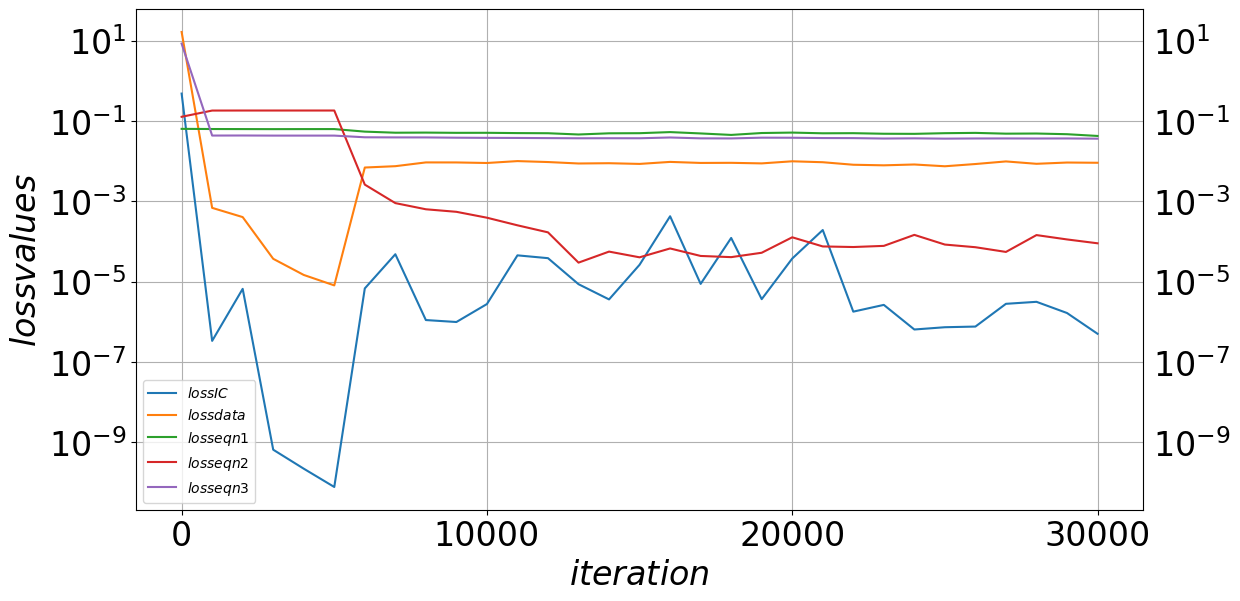

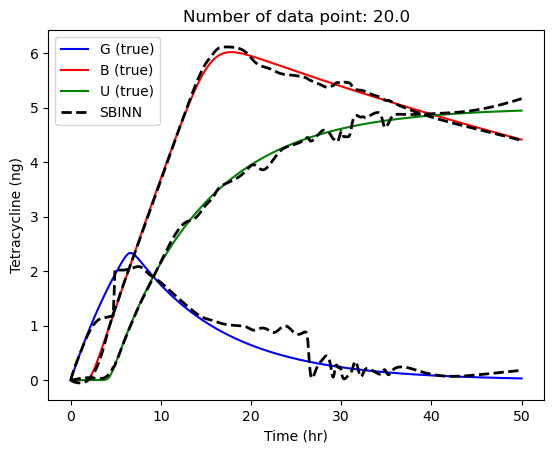

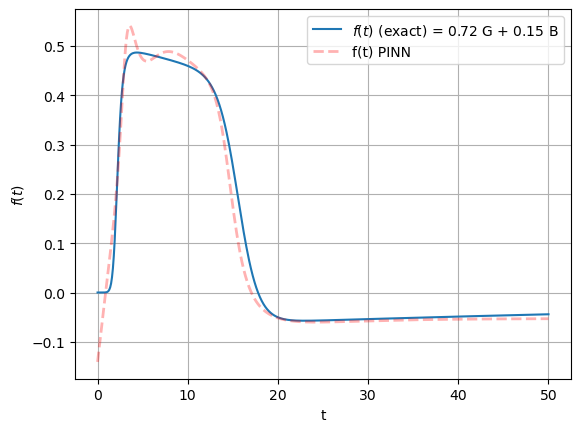

In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import time
import pandas as pd
import jaxopt
from scipy.integrate import odeint


def drug_model(
    t,
    k1 = 0.5,
    k2 = 0.5,
    k3 = 0.5,
    gamma1 = 0.1 ,
    gamma2 = 0.01 ,
    gamma3 = 0.1 ,
    c = 1 ,
    n = 9, 
):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]

        return [
            ((c**n)/((c**n)+ (U**n))  *k1) - gamma1*G,
            ((G**n)/((c**n)+ (G**n))  *k2) - gamma2*B,
            ((B**n)/((c**n)+ (B**n))  *k1) - gamma3*U,
            ]

    y0 = [0, 0, 0]
    return odeint(func, y0, t)


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

sample_rate = 25
dp=  500/sample_rate
t_data = t_dense[::sample_rate,0:1]
G_data = y_dense[::sample_rate,0:1]
B_data = y_dense[::sample_rate,1:2]
U_data = y_dense[::sample_rate,2:3]

data = jnp.concatenate([G_data, B_data, U_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([G_data[0:1,:], B_data[0:1,:], U_data[0:1,:]], axis=1)




tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params


def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  # X = X**2
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



def ODE_loss(t, y1, y2, y3, f_t):
    k1 = 0.5
    k2 = 0.5
    k3 = 0.5
    gamma1 = 0.1 
    gamma2 = 0.01 
    gamma3 = 0.1 
    c = 1 
    n = 9

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    ode1 = y1_t(t) -  (((c**n)/((c**n)+ (y1(t)**n))  *k1) - gamma1*y1(t))
    ode2 = y2_t(t) - f_t(t)
    ode3 = y3_t(t) - (((y2(t)**n)/((c**n)+ (y2(t)**n))  *k1) - gamma3*y1(t))

    return ode1, ode2, ode3




#collocation points
N_c = 500

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_extra,l1 ,l2 ,l3 , t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, y1_func, y2_func, y3_func, f_t)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2
    loss_y3 = l3*loss_y3

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3


def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    return loss_total


def loss_fun_total_lbfgs(params_total, t_i, t_d, t_c, data_IC, data, loss_weight):

    params, params_extra, l1,l2, l3 = params_total[0], params_total[1], params_total[2], params_total[3], params_total[4]

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1 ,l2, l3, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    print(f"Loss: {loss_total}")

    return loss_total




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)

  updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)

  return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-4)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)

lambda_1 = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))

opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)

#@title **two step training**


start_time = time.time()
epochs_phase1 = 5000
epochs_phase2 = 25000

loss_weight_phase1 = [1, 1, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,params,opt_state_extra,\
    params_extra, params_l1, params_l2,\
    params_l3, opt_state_l1,opt_state_l2, opt_state_l3 = update(opt_state, opt_state_extra, params, params_extra,\
                                                             lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                                              opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      print(f'Epoch={ep}, \t loss={loss_val:.3e}, \t loss_IC={loss_val_individual[0]:.3e}, \t loss_d={loss_val_individual[1]:.3e}, \t loss_e1={loss_val_individual[2]:.3e}, \t loss_e2={loss_val_individual[3]:.3e}, \t loss_e3={loss_val_individual[4]:.3e}')
      end_time = time.time()

      running_time = end_time - start_time
      print(f"Total running time: {running_time:.4f} seconds")






print("L-BFGS optimizer begins")

loss_weight = [1, 1, 1, 1, 1]

params_total = []
params_total.append(params)
params_total.append(params_extra)
params_total.append(params_l1)
params_total.append(params_l2)
params_total.append(params_l3)

start_time = time.time()

l_fun = lambda p_l: loss_fun_total_lbfgs(p_l, t_i, t_data, t_c, IC, data, loss_weight)

optimizer_lbfgs = jaxopt.LBFGS(fun=l_fun, history_size=100,  verbose=True, maxiter=100)
sol = optimizer_lbfgs.run(params_total)
params_total = sol.params

end_time = time.time()

running_time += end_time - start_time
print(f"Total running time: {running_time:.2f} seconds")

params = params_total[0]
params_extra = params_total[1]
np.savez(f'./params_{dp}.npz', *params)
np.savez(f'./params_extra_{dp}.npz', *params_extra)

k1 = 0.5,
k2 = 0.5,
k3 = 0.5,
gamma1 = 0.1 ,
gamma2 = 0.01 ,
gamma3 = 0.1 ,
c = 1 ,
n = 9,

SAVE_FIG = True
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig('./History_loss.png', dpi=300)




# pred = fwd(params,t_test)
pred = fwd(params,t_dense)
plt.figure()
plt.plot(t_dense, y_dense[:, 0:1],'-b',label='G (true)')
plt.plot(t_dense, y_dense[:, 1:2],'-r',label='B (true)')
plt.plot(t_dense, y_dense[:, 2:3],'-g',label='U (true)')

plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.plot(t_dense,pred[:,1],'--k',linewidth=2)
plt.plot(t_dense,pred[:,2],'--k',linewidth=2)
plt.title(f'Number of data point: {dp}')
plt.xlabel('Time (hr)')
plt.ylabel('Tetracycline (ng)')
plt.legend()
if SAVE_FIG:
    plt.savefig('./Pred.png', dpi=300)
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

f_t_analytical = (np.power(y_dense[:, 0],n))/((c**n)+ np.power(y_dense[:, 0],n)) *k2 - gamma2*y_dense[:, 1]  # 2nd equation
f_t_neural = fwd_extra(params_extra, t_dense)[:, 0]

G_pred = pred[:,0:1]
B_pred = pred[:,1:2]
U_pred = pred[:,2:3]
df_f = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred),"U": np.ravel(U_pred) ,"ft": np.ravel(f_t_neural) })
df_f.to_csv("./pred_20.csv", index=False)

plt.figure()
plt.plot(t_dense, f_t_analytical, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
plt.plot(t_dense, f_t_neural,'--r',linewidth=2, label='f(t) PINN', alpha=0.3)
plt.grid()
plt.xlabel('t')
plt.ylabel('$f(t)$')
plt.legend()
if SAVE_FIG:
    plt.savefig('./ft.png', dpi=300)




Epoch=0, 	 loss=1.665e+01, 	 loss_IC=4.828e-01, 	 loss_d=1.617e+01, 	 loss_e1=6.390e-02, 	 loss_e2=1.276e-01, 	 loss_e3=8.212e+00
Total running time: 6.8580 seconds
Epoch=1000, 	 loss=1.368e-04, 	 loss_IC=6.748e-08, 	 loss_d=1.368e-04, 	 loss_e1=6.266e-02, 	 loss_e2=1.808e-01, 	 loss_e3=4.306e-02
Total running time: 53.5291 seconds
Epoch=2000, 	 loss=7.496e-06, 	 loss_IC=1.092e-10, 	 loss_d=7.496e-06, 	 loss_e1=6.272e-02, 	 loss_e2=1.804e-01, 	 loss_e3=4.294e-02
Total running time: 98.4389 seconds
Epoch=3000, 	 loss=1.005e-03, 	 loss_IC=6.587e-05, 	 loss_d=9.392e-04, 	 loss_e1=6.230e-02, 	 loss_e2=1.803e-01, 	 loss_e3=4.246e-02
Total running time: 143.0768 seconds
Epoch=4000, 	 loss=3.789e-06, 	 loss_IC=1.528e-08, 	 loss_d=3.774e-06, 	 loss_e1=6.308e-02, 	 loss_e2=1.803e-01, 	 loss_e3=4.293e-02
Total running time: 187.5237 seconds
Epoch=5000, 	 loss=2.348e-06, 	 loss_IC=7.132e-13, 	 loss_d=2.348e-06, 	 loss_e1=6.333e-02, 	 loss_e2=1.804e-01, 	 loss_e3=4.292e-02
Total running time: 231.

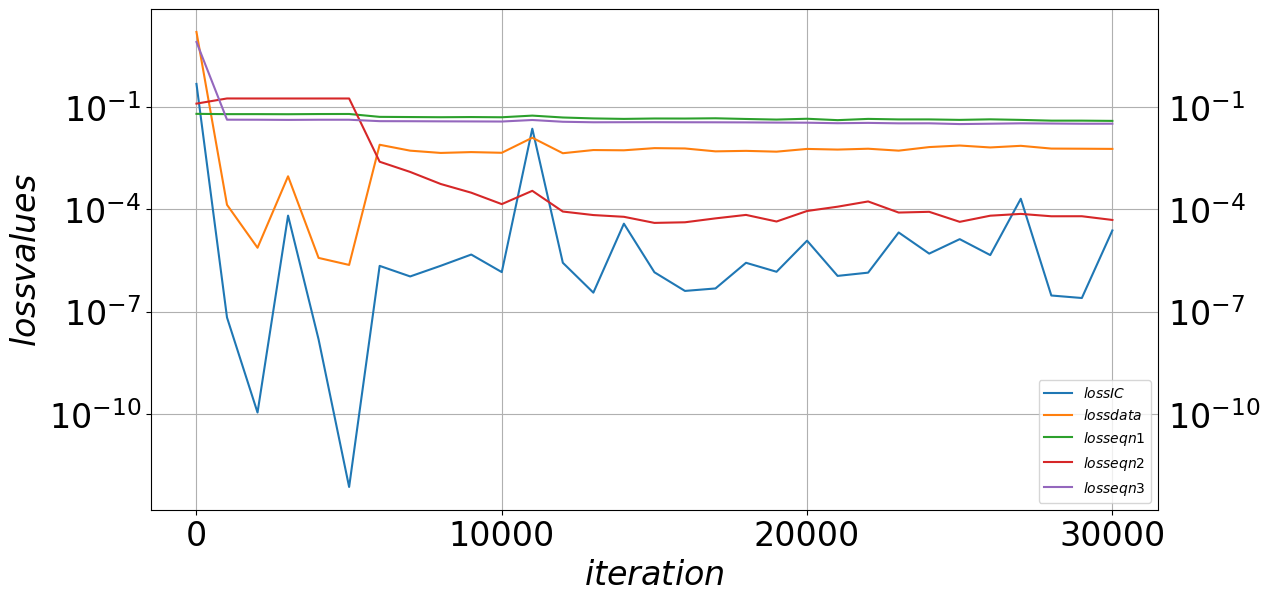

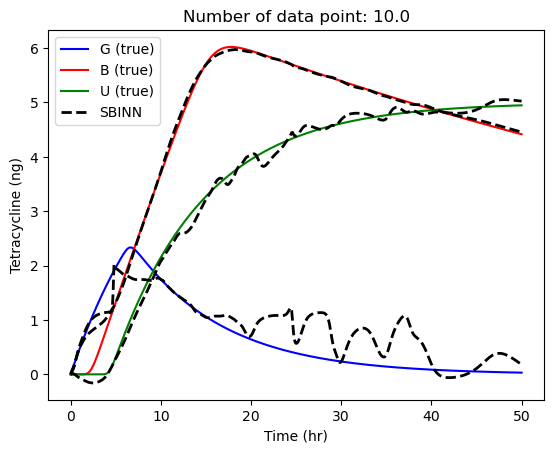

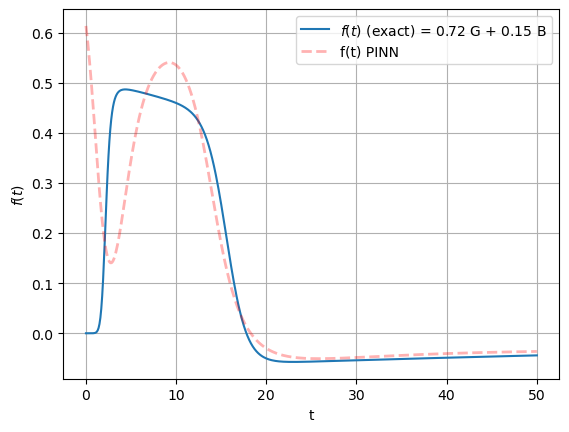

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import time
import pandas as pd
import jaxopt
from scipy.integrate import odeint


def drug_model(
    t,
    k1 = 0.5,
    k2 = 0.5,
    k3 = 0.5,
    gamma1 = 0.1 ,
    gamma2 = 0.01 ,
    gamma3 = 0.1 ,
    c = 1 ,
    n = 9, 
):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]

        return [
            ((c**n)/((c**n)+ (U**n))  *k1) - gamma1*G,
            ((G**n)/((c**n)+ (G**n))  *k2) - gamma2*B,
            ((B**n)/((c**n)+ (B**n))  *k1) - gamma3*U,
            ]

    y0 = [0, 0, 0]
    return odeint(func, y0, t)


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

sample_rate = 50
dp=  500/sample_rate
t_data = t_dense[::sample_rate,0:1]
G_data = y_dense[::sample_rate,0:1]
B_data = y_dense[::sample_rate,1:2]
U_data = y_dense[::sample_rate,2:3]

data = jnp.concatenate([G_data, B_data, U_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([G_data[0:1,:], B_data[0:1,:], U_data[0:1,:]], axis=1)




tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params


def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  # X = X**2
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



def ODE_loss(t, y1, y2, y3, f_t):
    k1 = 0.5
    k2 = 0.5
    k3 = 0.5
    gamma1 = 0.1 
    gamma2 = 0.01 
    gamma3 = 0.1 
    c = 1 
    n = 9

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    ode1 = y1_t(t) -  (((c**n)/((c**n)+ (y1(t)**n))  *k1) - gamma1*y1(t))
    ode2 = y2_t(t) - f_t(t)
    ode3 = y3_t(t) - (((y2(t)**n)/((c**n)+ (y2(t)**n))  *k1) - gamma3*y1(t))

    return ode1, ode2, ode3




#collocation points
N_c = 500

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_extra,l1 ,l2 ,l3 , t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, y1_func, y2_func, y3_func, f_t)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2
    loss_y3 = l3*loss_y3

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3


def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    return loss_total


def loss_fun_total_lbfgs(params_total, t_i, t_d, t_c, data_IC, data, loss_weight):

    params, params_extra, l1,l2, l3 = params_total[0], params_total[1], params_total[2], params_total[3], params_total[4]

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1 ,l2, l3, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    print(f"Loss: {loss_total}")

    return loss_total




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)

  updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)

  return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-4)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)

lambda_1 = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))

opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)

#@title **two step training**


start_time = time.time()
epochs_phase1 = 5000
epochs_phase2 = 25000

loss_weight_phase1 = [1, 1, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,params,opt_state_extra,\
    params_extra, params_l1, params_l2,\
    params_l3, opt_state_l1,opt_state_l2, opt_state_l3 = update(opt_state, opt_state_extra, params, params_extra,\
                                                             lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                                              opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      print(f'Epoch={ep}, \t loss={loss_val:.3e}, \t loss_IC={loss_val_individual[0]:.3e}, \t loss_d={loss_val_individual[1]:.3e}, \t loss_e1={loss_val_individual[2]:.3e}, \t loss_e2={loss_val_individual[3]:.3e}, \t loss_e3={loss_val_individual[4]:.3e}')
      end_time = time.time()

      running_time = end_time - start_time
      print(f"Total running time: {running_time:.4f} seconds")






print("L-BFGS optimizer begins")

loss_weight = [1, 1, 1, 1, 1]

params_total = []
params_total.append(params)
params_total.append(params_extra)
params_total.append(params_l1)
params_total.append(params_l2)
params_total.append(params_l3)

start_time = time.time()

l_fun = lambda p_l: loss_fun_total_lbfgs(p_l, t_i, t_data, t_c, IC, data, loss_weight)

optimizer_lbfgs = jaxopt.LBFGS(fun=l_fun, history_size=100,  verbose=True, maxiter=100)
sol = optimizer_lbfgs.run(params_total)
params_total = sol.params

end_time = time.time()

running_time += end_time - start_time
print(f"Total running time: {running_time:.2f} seconds")

params = params_total[0]
params_extra = params_total[1]
np.savez(f'./params_{dp}.npz', *params)
np.savez(f'./params_extra_{dp}.npz', *params_extra)

k1 = 0.5,
k2 = 0.5,
k3 = 0.5,
gamma1 = 0.1 ,
gamma2 = 0.01 ,
gamma3 = 0.1 ,
c = 1 ,
n = 9,

SAVE_FIG = True
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig('./History_loss.png', dpi=300)




# pred = fwd(params,t_test)
pred = fwd(params,t_dense)
plt.figure()
plt.plot(t_dense, y_dense[:, 0:1],'-b',label='G (true)')
plt.plot(t_dense, y_dense[:, 1:2],'-r',label='B (true)')
plt.plot(t_dense, y_dense[:, 2:3],'-g',label='U (true)')

plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.plot(t_dense,pred[:,1],'--k',linewidth=2)
plt.plot(t_dense,pred[:,2],'--k',linewidth=2)
plt.title(f'Number of data point: {dp}')
plt.xlabel('Time (hr)')
plt.ylabel('Tetracycline (ng)')
plt.legend()
if SAVE_FIG:
    plt.savefig('./Pred.png', dpi=300)
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9


t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

f_t_analytical = (np.power(y_dense[:, 0],n))/((c**n)+ np.power(y_dense[:, 0],n)) *k2 - gamma2*y_dense[:, 1]  # 2nd equation
f_t_neural = fwd_extra(params_extra, t_dense)[:, 0]

G_pred = pred[:,0:1]
B_pred = pred[:,1:2]
U_pred = pred[:,2:3]
df_f = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred),"U": np.ravel(U_pred) ,"ft": np.ravel(f_t_neural) })
df_f.to_csv("./pred_10.csv", index=False)

plt.figure()
plt.plot(t_dense, f_t_analytical, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
plt.plot(t_dense, f_t_neural,'--r',linewidth=2, label='f(t) PINN', alpha=0.3)
plt.grid()
plt.xlabel('t')
plt.ylabel('$f(t)$')
plt.legend()
if SAVE_FIG:
    plt.savefig('./ft.png', dpi=300)




_____________100 data points_____________
(MAE): 3.16e-02
(RMSE): 5.80e-02
(RE): 2.52e-01
_____________50 data points_____________
(MAE): 3.79e-02
(RMSE): 7.38e-02
(RE): 3.20e-01
_____________20 data points_____________
(MAE): 1.43e-02
(RMSE): 2.60e-02
(RE): 1.13e-01
_____________10 data points_____________
(MAE): 4.79e-02
(RMSE): 1.08e-01
(RE): 4.67e-01


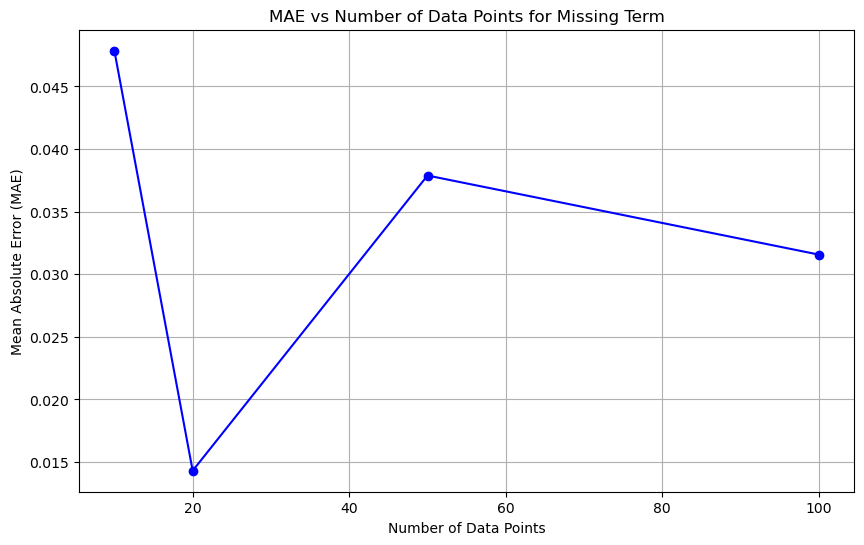

In [16]:
def compute_errors(true_values, predicted_values):
    # Compute Mean Absolute Error (MAE)
    mae = np.abs(true_values - predicted_values).mean()

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(((true_values - predicted_values) ** 2).mean())

    # Compute Relative Error (RE)
    numerator = np.sqrt(np.sum((true_values - predicted_values) ** 2))
    denominator = np.sqrt(np.sum(true_values ** 2))
    re = numerator / denominator

    return mae, rmse, re

df_100 = pd.read_csv("pred_100.csv")
ft_100 = df_100['ft']
print("_____________100 data points_____________")

mae_100, rmse, re  = compute_errors(f_t_analytical, ft_100)
print(f"(MAE): {mae_100:.2e}")
print(f"(RMSE): {rmse:.2e}")
print(f"(RE): {re:.2e}")

df_100 = pd.read_csv("pred_50.csv")
ft_100 = df_100['ft']
print("_____________50 data points_____________")

mae_50, rmse, re  = compute_errors(f_t_analytical, ft_100)
print(f"(MAE): {mae_50:.2e}")
print(f"(RMSE): {rmse:.2e}")
print(f"(RE): {re:.2e}")

df_100 = pd.read_csv("pred_20.csv")
ft_100 = df_100['ft']
print("_____________20 data points_____________")

mae_20, rmse, re  = compute_errors(f_t_analytical, ft_100)
print(f"(MAE): {mae_20:.2e}")
print(f"(RMSE): {rmse:.2e}")
print(f"(RE): {re:.2e}")

df_100 = pd.read_csv("pred_10.csv")
ft_100 = df_100['ft']
print("_____________10 data points_____________")

mae_10, rmse, re  = compute_errors(f_t_analytical, ft_100)
print(f"(MAE): {mae_10:.2e}")
print(f"(RMSE): {rmse:.2e}")
print(f"(RE): {re:.2e}")


plt.figure(figsize=(10, 6))
plt.plot([100, 50, 20, 10], [mae_100, mae_50, mae_20, mae_10], marker='o', linestyle='-', color='b')
plt.xlabel('Number of Data Points')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Number of Data Points for Missing Term')
plt.grid(True)
plt.savefig('MAE_Missing_Term.png')
plt.show()


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import time
from scipy.integrate import odeint

# Constants
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9
tmin, tmax = 0, 50

def drug_model(t, k1=0.5, k2=0.5, k3=0.5, gamma1=0.1, gamma2=0.01, gamma3=0.1, c=1, n=9):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]
        return [
            ((c**n)/((c**n) + (U**n)) * k1) - gamma1 * G,
            ((G**n)/((c**n) + (G**n)) * k2) - gamma2 * B,
            ((B**n)/((c**n) + (B**n)) * k3) - gamma3 * U,
        ]
    y0 = [0, 0, 0]
    return odeint(func, y0, t)

def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in)
        B = jax.random.normal(key, shape=(n_out,))
        k1 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k2 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k3 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        gamma1 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        gamma2 = jax.random.uniform(key, minval=0.0, maxval=0.1)
        gamma3 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        params.append({'W': W, 'B': B, 'k1': k1, 'k2': k2, 'k3': k3, 'gamma1': gamma1, 'gamma2': gamma2, 'gamma3': gamma3})
    return params

def fwd(params, t):
    X = jnp.concatenate([t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def ODE_loss(t, params, y1, y2, y3):
    k1, k2, k3 = params[-1]['k1'], params[-1]['k2'], params[-1]['k3']
    gamma1, gamma2, gamma3 = params[-1]['gamma1'], params[-1]['gamma2'], params[-1]['gamma3']
    c, n = 1, 9

    y1_t = jax.grad(lambda t: jnp.sum(y1(t)), argnums=0)
    y2_t = jax.grad(lambda t: jnp.sum(y2(t)), argnums=0)
    y3_t = jax.grad(lambda t: jnp.sum(y3(t)), argnums=0)
    
    ode1 = y1_t(t) - ((c**n / (c**n + y3(t)**n) * k1) - gamma1 * y1(t))
    ode2 = y2_t(t) - ((y1(t)**n / (c**n + y1(t)**n) * k2) - gamma2 * y2(t))
    ode3 = y3_t(t) - ((y2(t)**n / (c**n + y2(t)**n) * k3) - gamma3 * y3(t))

    return ode1, ode2, ode3

def loss_fun(params, t_i, t_d, t_c, data_IC, data):
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:, None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)], axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d = t_d.flatten()[:, None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)], axis=1)
    loss_data = MSE(data, pred_d)

    return loss_IC + loss_data + loss_ode1 + loss_ode2 + loss_ode3

@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data):
    grads = jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

def run_simulation(seed):
    # Initialize lists to store values
    loss_values = []
    k1_values_list = []
    k2_values_list = []
    k3_values_list = []
    gamma1_values_list = []
    gamma2_values_list = []
    gamma3_values_list = []
    epoch_numbers = []

    params = init_params([1] + [20] * 4 + [3], seed)
    opt_state = optimizer.init(params)

    epochs = 50000
    start_time = time.time()

    t_i  = jnp.array([[0]])

    for ep in range(epochs):
        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data)

        if ep % 1000 == 0:
            loss = loss_fun(params, t_i, t_data, t_c, IC, data)
            loss_values.append(loss)
            k1_updated = params[-1]['k1']
            k2_updated = params[-1]['k2']
            k3_updated = params[-1]['k3']
            gamma1_updated = params[-1]['gamma1']
            gamma2_updated = params[-1]['gamma2']
            gamma3_updated = params[-1]['gamma3']

            print(f'Epoch={ep} \t loss={loss:.3e} \t k1= {k1_updated} \t k2={k2_updated} \t k3= {k3_updated} \t gamma1={gamma1_updated}\t gamma2= {gamma2_updated} \t gamma3={gamma3_updated}')

            k1_values_list.append(k1_updated)
            k2_values_list.append(k2_updated)
            k3_values_list.append(k3_updated)
            gamma1_values_list.append(gamma1_updated)
            gamma2_values_list.append(gamma2_updated)
            gamma3_values_list.append(gamma3_updated)
            epoch_numbers.append(ep)

            end_time = time.time()
            running_time = end_time - start_time
            print(f"Total running time: {running_time:.4f} seconds")
    
    return k1_updated, k2_updated, k3_updated, gamma1_updated, gamma2_updated, gamma3_updated

# Set up initial conditions and data
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))
sample_rate = 10
t_data = t_dense[::sample_rate, 0:1]
G_data = y_dense[::sample_rate, 0:1]
B_data = y_dense[::sample_rate, 1:2]
U_data = y_dense[::sample_rate, 2:3]
data = jnp.concatenate([G_data, B_data, U_data], axis=1)

t_IC = jnp.array([[0]])
IC = jnp.array([[0, 0, 0]])

t_c = jnp.linspace(tmin, tmax, 501)[:, None]

optimizer = optax.adam(1e-4)

# Run the simulation 10 times with different seeds
final_k1_values = []
final_k2_values = []
final_k3_values = []
final_gamma1_values = []
final_gamma2_values = []
final_gamma3_values = []
used_seeds = []

for i in range(10):
    seed = np.random.randint(0, 10000)
    used_seeds.append(seed)
    print(f'################Run the simulation {i} time with different seed: {seed} ##################')
    k1, k2, k3, gamma1, gamma2, gamma3 = run_simulation(seed)
    final_k1_values.append(np.abs(0.5 - k1))
    final_k2_values.append(np.abs(0.5 - k2))
    final_k3_values.append(np.abs(0.5 - k3))
    final_gamma1_values.append(np.abs(0.1 - gamma1))
    final_gamma2_values.append(np.abs(0.01 - gamma2))
    final_gamma3_values.append(np.abs(0.1 - gamma3))
    print(f'k1 absolute error: {final_k1_values}')
    print(f'k2 absolute error: {final_k2_values}')
    print(f'k3 absolute error: {final_k3_values}')
    print(f'gamma1 absolute error: {final_gamma1_values}')
    print(f'gamma2 absolute error: {final_gamma2_values}')
    print(f'gamma3 absolute error: {final_gamma3_values}')



final_k1_values = np.array([value for value in final_k1_values if not np.isnan(value)])
final_k2_values = np.array([value for value in final_k2_values if not np.isnan(value)])
final_k3_values = np.array([value for value in final_k3_values if not np.isnan(value)])
final_gamma1_values = np.array([value for value in final_gamma1_values if not np.isnan(value)])
final_gamma2_values = np.array([value for value in final_gamma2_values if not np.isnan(value)])
final_gamma3_values = np.array([value for value in final_gamma3_values if not np.isnan(value)])

# Calculate and print the average
average_k1 = np.mean(final_k1_values)
average_k2 = np.mean(final_k2_values)
average_k3 = np.mean(final_k3_values)
average_gamma1 = np.mean(final_gamma1_values)
average_gamma2 = np.mean(final_gamma2_values)
average_gamma3 = np.mean(final_gamma3_values)

print(f'Average k1 absolute error: {average_k1}')
print(f'Average k2 absolute error: {average_k2}')
print(f'Average k3 absolute error: {average_k3}')
print(f'Average gamma1 absolute error: {average_gamma1}')
print(f'Average gamma2 absolute error: {average_gamma2}')
print(f'Average gamma3 absolute error: {average_gamma3}')


################Run the simulation 0 time with different seed: 6743 ##################
Epoch=0 	 loss=1.769e+01 	 k1= 0.08185584843158722 	 k2=0.08165659010410309 	 k3= 0.08185659348964691 	 gamma1=0.04077829793095589	 gamma2= 0.008075660094618797 	 gamma3=0.04077829793095589
Total running time: 9.1130 seconds
Epoch=1000 	 loss=1.242e+01 	 k1= 0.1369442492723465 	 k2=0.07036000490188599 	 k3= 0.010920027270913124 	 gamma1=0.003067950950935483	 gamma2= -0.00025622628163546324 	 gamma3=0.046475183218717575
Total running time: 13.4998 seconds
Epoch=2000 	 loss=1.206e+01 	 k1= 0.048528041690588 	 k2=0.07035176455974579 	 k3= 0.011313124559819698 	 gamma1=-0.007454667240381241	 gamma2= 0.0003953822306357324 	 gamma3=-0.00022137326595839113
Total running time: 18.3087 seconds
Epoch=3000 	 loss=1.185e+01 	 k1= 0.051580674946308136 	 k2=0.07031085342168808 	 k3= 0.011509055271744728 	 gamma1=-0.009069675579667091	 gamma2= 0.00041287383646704257 	 gamma3=-0.004433074966073036
Total running time

In [2]:
k1_50_error = average_k1 
k2_50_error = average_k2 
k3_50_error = average_k3 
gamma1_50_error = average_gamma1
gamma2_50_error = average_gamma2 
gamma3_50_error = average_gamma3 

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import time
from scipy.integrate import odeint

# Constants
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9
tmin, tmax = 0, 50

def drug_model(t, k1=0.5, k2=0.5, k3=0.5, gamma1=0.1, gamma2=0.01, gamma3=0.1, c=1, n=9):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]
        return [
            ((c**n)/((c**n) + (U**n)) * k1) - gamma1 * G,
            ((G**n)/((c**n) + (G**n)) * k2) - gamma2 * B,
            ((B**n)/((c**n) + (B**n)) * k3) - gamma3 * U,
        ]
    y0 = [0, 0, 0]
    return odeint(func, y0, t)

def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in)
        B = jax.random.normal(key, shape=(n_out,))
        k1 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k2 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k3 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        gamma1 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        gamma2 = jax.random.uniform(key, minval=0.0, maxval=0.1)
        gamma3 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        params.append({'W': W, 'B': B, 'k1': k1, 'k2': k2, 'k3': k3, 'gamma1': gamma1, 'gamma2': gamma2, 'gamma3': gamma3})
    return params

def fwd(params, t):
    X = jnp.concatenate([t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def ODE_loss(t, params, y1, y2, y3):
    k1, k2, k3 = params[-1]['k1'], params[-1]['k2'], params[-1]['k3']
    gamma1, gamma2, gamma3 = params[-1]['gamma1'], params[-1]['gamma2'], params[-1]['gamma3']
    c, n = 1, 9

    y1_t = jax.grad(lambda t: jnp.sum(y1(t)), argnums=0)
    y2_t = jax.grad(lambda t: jnp.sum(y2(t)), argnums=0)
    y3_t = jax.grad(lambda t: jnp.sum(y3(t)), argnums=0)
    
    ode1 = y1_t(t) - ((c**n / (c**n + y3(t)**n) * k1) - gamma1 * y1(t))
    ode2 = y2_t(t) - ((y1(t)**n / (c**n + y1(t)**n) * k2) - gamma2 * y2(t))
    ode3 = y3_t(t) - ((y2(t)**n / (c**n + y2(t)**n) * k3) - gamma3 * y3(t))

    return ode1, ode2, ode3

def loss_fun(params, t_i, t_d, t_c, data_IC, data):
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:, None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)], axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d = t_d.flatten()[:, None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)], axis=1)
    loss_data = MSE(data, pred_d)

    return loss_IC + loss_data + loss_ode1 + loss_ode2 + loss_ode3

@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data):
    grads = jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

def run_simulation(seed):
    # Initialize lists to store values
    loss_values = []
    k1_values_list = []
    k2_values_list = []
    k3_values_list = []
    gamma1_values_list = []
    gamma2_values_list = []
    gamma3_values_list = []
    epoch_numbers = []

    params = init_params([1] + [20] * 4 + [3], seed)
    opt_state = optimizer.init(params)

    epochs = 50000
    start_time = time.time()

    t_i  = jnp.array([[0]])

    for ep in range(epochs):
        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data)

        if ep % 1000 == 0:
            loss = loss_fun(params, t_i, t_data, t_c, IC, data)
            loss_values.append(loss)
            k1_updated = params[-1]['k1']
            k2_updated = params[-1]['k2']
            k3_updated = params[-1]['k3']
            gamma1_updated = params[-1]['gamma1']
            gamma2_updated = params[-1]['gamma2']
            gamma3_updated = params[-1]['gamma3']

            print(f'Epoch={ep} \t loss={loss:.3e} \t k1= {k1_updated} \t k2={k2_updated} \t k3= {k3_updated} \t gamma1={gamma1_updated}\t gamma2= {gamma2_updated} \t gamma3={gamma3_updated}')

            k1_values_list.append(k1_updated)
            k2_values_list.append(k2_updated)
            k3_values_list.append(k3_updated)
            gamma1_values_list.append(gamma1_updated)
            gamma2_values_list.append(gamma2_updated)
            gamma3_values_list.append(gamma3_updated)
            epoch_numbers.append(ep)

            end_time = time.time()
            running_time = end_time - start_time
            print(f"Total running time: {running_time:.4f} seconds")
    
    return k1_updated, k2_updated, k3_updated, gamma1_updated, gamma2_updated, gamma3_updated

# Set up initial conditions and data
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))
sample_rate = 50
t_data = t_dense[::sample_rate, 0:1]
G_data = y_dense[::sample_rate, 0:1]
B_data = y_dense[::sample_rate, 1:2]
U_data = y_dense[::sample_rate, 2:3]
data = jnp.concatenate([G_data, B_data, U_data], axis=1)

t_IC = jnp.array([[0]])
IC = jnp.array([[0, 0, 0]])

t_c = jnp.linspace(tmin, tmax, 501)[:, None]

optimizer = optax.adam(1e-4)

# Run the simulation 10 times with different seeds
final_k1_values = []
final_k2_values = []
final_k3_values = []
final_gamma1_values = []
final_gamma2_values = []
final_gamma3_values = []
used_seeds = []

for i in range(10):
    seed = np.random.randint(0, 10000)
    used_seeds.append(seed)
    print(f'################Run the simulation {i} time with different seed: {seed} ##################')
    k1, k2, k3, gamma1, gamma2, gamma3 = run_simulation(seed)
    final_k1_values.append(np.abs(0.5 - k1))
    final_k2_values.append(np.abs(0.5 - k2))
    final_k3_values.append(np.abs(0.5 - k3))
    final_gamma1_values.append(np.abs(0.1 - gamma1))
    final_gamma2_values.append(np.abs(0.01 - gamma2))
    final_gamma3_values.append(np.abs(0.1 - gamma3))
    print(f'k1 absolute error: {final_k1_values}')
    print(f'k2 absolute error: {final_k2_values}')
    print(f'k3 absolute error: {final_k3_values}')
    print(f'gamma1 absolute error: {final_gamma1_values}')
    print(f'gamma2 absolute error: {final_gamma2_values}')
    print(f'gamma3 absolute error: {final_gamma3_values}')



final_k1_values = np.array([value for value in final_k1_values if not np.isnan(value)])
final_k2_values = np.array([value for value in final_k2_values if not np.isnan(value)])
final_k3_values = np.array([value for value in final_k3_values if not np.isnan(value)])
final_gamma1_values = np.array([value for value in final_gamma1_values if not np.isnan(value)])
final_gamma2_values = np.array([value for value in final_gamma2_values if not np.isnan(value)])
final_gamma3_values = np.array([value for value in final_gamma3_values if not np.isnan(value)])

# Calculate and print the average
average_k1 = np.mean(final_k1_values)
average_k2 = np.mean(final_k2_values)
average_k3 = np.mean(final_k3_values)
average_gamma1 = np.mean(final_gamma1_values)
average_gamma2 = np.mean(final_gamma2_values)
average_gamma3 = np.mean(final_gamma3_values)

print(f'Average k1 absolute error: {average_k1}')
print(f'Average k2 absolute error: {average_k2}')
print(f'Average k3 absolute error: {average_k3}')
print(f'Average gamma1 absolute error: {average_gamma1}')
print(f'Average gamma2 absolute error: {average_gamma2}')
print(f'Average gamma3 absolute error: {average_gamma3}')


################Run the simulation 0 time with different seed: 7464 ##################
Epoch=0 	 loss=1.757e+01 	 k1= 0.4194914996623993 	 k2=0.41929152607917786 	 k3= 0.4194910526275635 	 gamma1=0.20959575474262238	 gamma2= 0.04203914850950241 	 gamma3=0.20959575474262238
Total running time: 9.3687 seconds
Epoch=1000 	 loss=9.372e+00 	 k1= 0.3144144117832184 	 k2=0.41273167729377747 	 k3= 0.2834821343421936 	 gamma1=0.25059282779693604	 gamma2= -0.011507539078593254 	 gamma3=0.10010562092065811
Total running time: 13.7358 seconds
Epoch=2000 	 loss=8.653e+00 	 k1= 0.20258696377277374 	 k2=0.42562130093574524 	 k3= 0.20546655356884003 	 gamma1=0.1418267786502838	 gamma2= -0.012400133535265923 	 gamma3=0.02383319102227688
Total running time: 17.9197 seconds
Epoch=3000 	 loss=8.336e+00 	 k1= 0.08172345161437988 	 k2=0.5333122611045837 	 k3= 0.14852374792099 	 gamma1=0.01744457334280014	 gamma2= -0.0011946741724386811 	 gamma3=-0.03098548948764801
Total running time: 22.0631 seconds
Epoch=

In [11]:
k1_error = []
k2_error = []
k3_error = []
gamma1_error = []
gamma2_error = []
gamma3_error= []


k1_error.append(average_k1*100/0.5)
k2_error.append(average_k2*100/0.5)
k3_error.append(average_k3*100/0.5)
gamma1_error.append(average_gamma1*100/0.1)
gamma2_error.append(average_gamma2*100/0.01)
gamma3_error.append(average_gamma3*100/0.1)


k1_conv = []
k2_conv = []
k3_conv = []
gamma1_conv = []
gamma2_conv = []
gamma3_conv = []

k1_conv.append(6)
k2_conv.append(6)
k3_conv.append(8)
gamma1_conv.append(6)
gamma2_conv.append(5)
gamma3_conv.append(8)

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import time
from scipy.integrate import odeint

# Constants
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9
tmin, tmax = 0, 50

def drug_model(t, k1=0.5, k2=0.5, k3=0.5, gamma1=0.1, gamma2=0.01, gamma3=0.1, c=1, n=9):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]
        return [
            ((c**n)/((c**n) + (U**n)) * k1) - gamma1 * G,
            ((G**n)/((c**n) + (G**n)) * k2) - gamma2 * B,
            ((B**n)/((c**n) + (B**n)) * k3) - gamma3 * U,
        ]
    y0 = [0, 0, 0]
    return odeint(func, y0, t)

def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in)
        B = jax.random.normal(key, shape=(n_out,))
        k1 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k2 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k3 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        gamma1 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        gamma2 = jax.random.uniform(key, minval=0.0, maxval=0.1)
        gamma3 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        params.append({'W': W, 'B': B, 'k1': k1, 'k2': k2, 'k3': k3, 'gamma1': gamma1, 'gamma2': gamma2, 'gamma3': gamma3})
    return params

def fwd(params, t):
    X = jnp.concatenate([t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def ODE_loss(t, params, y1, y2, y3):
    k1, k2, k3 = params[-1]['k1'], params[-1]['k2'], params[-1]['k3']
    gamma1, gamma2, gamma3 = params[-1]['gamma1'], params[-1]['gamma2'], params[-1]['gamma3']
    c, n = 1, 9

    y1_t = jax.grad(lambda t: jnp.sum(y1(t)), argnums=0)
    y2_t = jax.grad(lambda t: jnp.sum(y2(t)), argnums=0)
    y3_t = jax.grad(lambda t: jnp.sum(y3(t)), argnums=0)
    
    ode1 = y1_t(t) - ((c**n / (c**n + y3(t)**n) * k1) - gamma1 * y1(t))
    ode2 = y2_t(t) - ((y1(t)**n / (c**n + y1(t)**n) * k2) - gamma2 * y2(t))
    ode3 = y3_t(t) - ((y2(t)**n / (c**n + y2(t)**n) * k3) - gamma3 * y3(t))

    return ode1, ode2, ode3

def loss_fun(params, t_i, t_d, t_c, data_IC, data):
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:, None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)], axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d = t_d.flatten()[:, None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)], axis=1)
    loss_data = MSE(data, pred_d)

    return loss_IC + loss_data + loss_ode1 + loss_ode2 + loss_ode3

@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data):
    grads = jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

def run_simulation(seed):
    # Initialize lists to store values
    loss_values = []
    k1_values_list = []
    k2_values_list = []
    k3_values_list = []
    gamma1_values_list = []
    gamma2_values_list = []
    gamma3_values_list = []
    epoch_numbers = []

    params = init_params([1] + [20] * 4 + [3], seed)
    opt_state = optimizer.init(params)

    epochs = 50000
    start_time = time.time()

    t_i  = jnp.array([[0]])

    for ep in range(epochs):
        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data)

        if ep % 1000 == 0:
            loss = loss_fun(params, t_i, t_data, t_c, IC, data)
            loss_values.append(loss)
            k1_updated = params[-1]['k1']
            k2_updated = params[-1]['k2']
            k3_updated = params[-1]['k3']
            gamma1_updated = params[-1]['gamma1']
            gamma2_updated = params[-1]['gamma2']
            gamma3_updated = params[-1]['gamma3']

            print(f'Epoch={ep} \t loss={loss:.3e} \t k1= {k1_updated} \t k2={k2_updated} \t k3= {k3_updated} \t gamma1={gamma1_updated}\t gamma2= {gamma2_updated} \t gamma3={gamma3_updated}')

            k1_values_list.append(k1_updated)
            k2_values_list.append(k2_updated)
            k3_values_list.append(k3_updated)
            gamma1_values_list.append(gamma1_updated)
            gamma2_values_list.append(gamma2_updated)
            gamma3_values_list.append(gamma3_updated)
            epoch_numbers.append(ep)

            end_time = time.time()
            running_time = end_time - start_time
            print(f"Total running time: {running_time:.4f} seconds")
    
    return k1_updated, k2_updated, k3_updated, gamma1_updated, gamma2_updated, gamma3_updated

# Set up initial conditions and data
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))
sample_rate = 25
t_data = t_dense[::sample_rate, 0:1]
G_data = y_dense[::sample_rate, 0:1]
B_data = y_dense[::sample_rate, 1:2]
U_data = y_dense[::sample_rate, 2:3]
data = jnp.concatenate([G_data, B_data, U_data], axis=1)

t_IC = jnp.array([[0]])
IC = jnp.array([[0, 0, 0]])

t_c = jnp.linspace(tmin, tmax, 501)[:, None]

optimizer = optax.adam(1e-4)

# Run the simulation 10 times with different seeds
final_k1_values = []
final_k2_values = []
final_k3_values = []
final_gamma1_values = []
final_gamma2_values = []
final_gamma3_values = []
used_seeds = []

for i in range(10):
    seed = np.random.randint(0, 10000)
    used_seeds.append(seed)
    print(f'################Run the simulation {i} time with different seed: {seed} ##################')
    k1, k2, k3, gamma1, gamma2, gamma3 = run_simulation(seed)
    final_k1_values.append(np.abs(0.5 - k1))
    final_k2_values.append(np.abs(0.5 - k2))
    final_k3_values.append(np.abs(0.5 - k3))
    final_gamma1_values.append(np.abs(0.1 - gamma1))
    final_gamma2_values.append(np.abs(0.01 - gamma2))
    final_gamma3_values.append(np.abs(0.1 - gamma3))
    print(f'k1 absolute error: {final_k1_values}')
    print(f'k2 absolute error: {final_k2_values}')
    print(f'k3 absolute error: {final_k3_values}')
    print(f'gamma1 absolute error: {final_gamma1_values}')
    print(f'gamma2 absolute error: {final_gamma2_values}')
    print(f'gamma3 absolute error: {final_gamma3_values}')



final_k1_values = np.array([value for value in final_k1_values if not np.isnan(value)])
final_k2_values = np.array([value for value in final_k2_values if not np.isnan(value)])
final_k3_values = np.array([value for value in final_k3_values if not np.isnan(value)])
final_gamma1_values = np.array([value for value in final_gamma1_values if not np.isnan(value)])
final_gamma2_values = np.array([value for value in final_gamma2_values if not np.isnan(value)])
final_gamma3_values = np.array([value for value in final_gamma3_values if not np.isnan(value)])

# Calculate and print the average
average_k1 = np.mean(final_k1_values)
average_k2 = np.mean(final_k2_values)
average_k3 = np.mean(final_k3_values)
average_gamma1 = np.mean(final_gamma1_values)
average_gamma2 = np.mean(final_gamma2_values)
average_gamma3 = np.mean(final_gamma3_values)

print(f'Average k1 absolute error: {average_k1}')
print(f'Average k2 absolute error: {average_k2}')
print(f'Average k3 absolute error: {average_k3}')
print(f'Average gamma1 absolute error: {average_gamma1}')
print(f'Average gamma2 absolute error: {average_gamma2}')
print(f'Average gamma3 absolute error: {average_gamma3}')


################Run the simulation 0 time with different seed: 4920 ##################
Epoch=0 	 loss=2.039e+01 	 k1= 0.8451248407363892 	 k2=0.8451248407363892 	 k3= 0.8453248739242554 	 gamma1=0.4225124418735504	 gamma2= 0.08442248404026031 	 gamma3=0.4225124418735504
Total running time: 7.3752 seconds
Epoch=1000 	 loss=1.420e+01 	 k1= 0.73419588804245 	 k2=0.8411537408828735 	 k3= 0.695239245891571 	 gamma1=0.3919459283351898	 gamma2= -0.004008602350950241 	 gamma3=0.3209366798400879
Total running time: 11.8031 seconds
Epoch=2000 	 loss=9.927e+00 	 k1= 0.6300457715988159 	 k2=0.8411350846290588 	 k3= 0.5353094935417175 	 gamma1=0.2768763601779938	 gamma2= -0.011902929283678532 	 gamma3=0.2059551328420639
Total running time: 16.0181 seconds
Epoch=3000 	 loss=9.102e+00 	 k1= 0.527671754360199 	 k2=1.0059772729873657 	 k3= 0.4427204728126526 	 gamma1=0.14919111132621765	 gamma2= -0.004275732673704624 	 gamma3=0.11923474818468094
Total running time: 20.3690 seconds
Epoch=4000 	 loss=8.8

In [13]:


k1_error.append(average_k1*100/0.5)
k2_error.append(average_k2*100/0.5)
k3_error.append(average_k3*100/0.5)
gamma1_error.append(average_gamma1*100/0.1)
gamma2_error.append(average_gamma2*100/0.01)
gamma3_error.append(average_gamma3*100/0.1)

k1_conv.append(9)
k2_conv.append(7)
k3_conv.append(7)
gamma1_conv.append(9)
gamma2_conv.append(8)
gamma3_conv.append(7)

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import time
from scipy.integrate import odeint

# Constants
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9
tmin, tmax = 0, 50

def drug_model(t, k1=0.5, k2=0.5, k3=0.5, gamma1=0.1, gamma2=0.01, gamma3=0.1, c=1, n=9):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]
        return [
            ((c**n)/((c**n) + (U**n)) * k1) - gamma1 * G,
            ((G**n)/((c**n) + (G**n)) * k2) - gamma2 * B,
            ((B**n)/((c**n) + (B**n)) * k3) - gamma3 * U,
        ]
    y0 = [0, 0, 0]
    return odeint(func, y0, t)

def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in)
        B = jax.random.normal(key, shape=(n_out,))
        k1 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k2 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k3 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        gamma1 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        gamma2 = jax.random.uniform(key, minval=0.0, maxval=0.1)
        gamma3 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        params.append({'W': W, 'B': B, 'k1': k1, 'k2': k2, 'k3': k3, 'gamma1': gamma1, 'gamma2': gamma2, 'gamma3': gamma3})
    return params

def fwd(params, t):
    X = jnp.concatenate([t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def ODE_loss(t, params, y1, y2, y3):
    k1, k2, k3 = params[-1]['k1'], params[-1]['k2'], params[-1]['k3']
    gamma1, gamma2, gamma3 = params[-1]['gamma1'], params[-1]['gamma2'], params[-1]['gamma3']
    c, n = 1, 9

    y1_t = jax.grad(lambda t: jnp.sum(y1(t)), argnums=0)
    y2_t = jax.grad(lambda t: jnp.sum(y2(t)), argnums=0)
    y3_t = jax.grad(lambda t: jnp.sum(y3(t)), argnums=0)
    
    ode1 = y1_t(t) - ((c**n / (c**n + y3(t)**n) * k1) - gamma1 * y1(t))
    ode2 = y2_t(t) - ((y1(t)**n / (c**n + y1(t)**n) * k2) - gamma2 * y2(t))
    ode3 = y3_t(t) - ((y2(t)**n / (c**n + y2(t)**n) * k3) - gamma3 * y3(t))

    return ode1, ode2, ode3

def loss_fun(params, t_i, t_d, t_c, data_IC, data):
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:, None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)], axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d = t_d.flatten()[:, None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)], axis=1)
    loss_data = MSE(data, pred_d)

    return loss_IC + loss_data + loss_ode1 + loss_ode2 + loss_ode3

@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data):
    grads = jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

def run_simulation(seed):
    # Initialize lists to store values
    loss_values = []
    k1_values_list = []
    k2_values_list = []
    k3_values_list = []
    gamma1_values_list = []
    gamma2_values_list = []
    gamma3_values_list = []
    epoch_numbers = []

    params = init_params([1] + [20] * 4 + [3], seed)
    opt_state = optimizer.init(params)

    epochs = 50000
    start_time = time.time()

    t_i  = jnp.array([[0]])

    for ep in range(epochs):
        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data)

        if ep % 1000 == 0:
            loss = loss_fun(params, t_i, t_data, t_c, IC, data)
            loss_values.append(loss)
            k1_updated = params[-1]['k1']
            k2_updated = params[-1]['k2']
            k3_updated = params[-1]['k3']
            gamma1_updated = params[-1]['gamma1']
            gamma2_updated = params[-1]['gamma2']
            gamma3_updated = params[-1]['gamma3']

            print(f'Epoch={ep} \t loss={loss:.3e} \t k1= {k1_updated} \t k2={k2_updated} \t k3= {k3_updated} \t gamma1={gamma1_updated}\t gamma2= {gamma2_updated} \t gamma3={gamma3_updated}')

            k1_values_list.append(k1_updated)
            k2_values_list.append(k2_updated)
            k3_values_list.append(k3_updated)
            gamma1_values_list.append(gamma1_updated)
            gamma2_values_list.append(gamma2_updated)
            gamma3_values_list.append(gamma3_updated)
            epoch_numbers.append(ep)

            end_time = time.time()
            running_time = end_time - start_time
            print(f"Total running time: {running_time:.4f} seconds")
    
    return k1_updated, k2_updated, k3_updated, gamma1_updated, gamma2_updated, gamma3_updated

# Set up initial conditions and data
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))
sample_rate = 10
t_data = t_dense[::sample_rate, 0:1]
G_data = y_dense[::sample_rate, 0:1]
B_data = y_dense[::sample_rate, 1:2]
U_data = y_dense[::sample_rate, 2:3]
data = jnp.concatenate([G_data, B_data, U_data], axis=1)

t_IC = jnp.array([[0]])
IC = jnp.array([[0, 0, 0]])

t_c = jnp.linspace(tmin, tmax, 501)[:, None]

optimizer = optax.adam(1e-4)

# Run the simulation 10 times with different seeds
final_k1_values = []
final_k2_values = []
final_k3_values = []
final_gamma1_values = []
final_gamma2_values = []
final_gamma3_values = []
used_seeds = []

for i in range(10):
    seed = np.random.randint(0, 10000)
    used_seeds.append(seed)
    print(f'################Run the simulation {i} time with different seed: {seed} ##################')
    k1, k2, k3, gamma1, gamma2, gamma3 = run_simulation(seed)
    final_k1_values.append(np.abs(0.5 - k1))
    final_k2_values.append(np.abs(0.5 - k2))
    final_k3_values.append(np.abs(0.5 - k3))
    final_gamma1_values.append(np.abs(0.1 - gamma1))
    final_gamma2_values.append(np.abs(0.01 - gamma2))
    final_gamma3_values.append(np.abs(0.1 - gamma3))
    print(f'k1 absolute error: {final_k1_values}')
    print(f'k2 absolute error: {final_k2_values}')
    print(f'k3 absolute error: {final_k3_values}')
    print(f'gamma1 absolute error: {final_gamma1_values}')
    print(f'gamma2 absolute error: {final_gamma2_values}')
    print(f'gamma3 absolute error: {final_gamma3_values}')



final_k1_values = np.array([value for value in final_k1_values if not np.isnan(value)])
final_k2_values = np.array([value for value in final_k2_values if not np.isnan(value)])
final_k3_values = np.array([value for value in final_k3_values if not np.isnan(value)])
final_gamma1_values = np.array([value for value in final_gamma1_values if not np.isnan(value)])
final_gamma2_values = np.array([value for value in final_gamma2_values if not np.isnan(value)])
final_gamma3_values = np.array([value for value in final_gamma3_values if not np.isnan(value)])

# Calculate and print the average
average_k1 = np.mean(final_k1_values)
average_k2 = np.mean(final_k2_values)
average_k3 = np.mean(final_k3_values)
average_gamma1 = np.mean(final_gamma1_values)
average_gamma2 = np.mean(final_gamma2_values)
average_gamma3 = np.mean(final_gamma3_values)

print(f'Average k1 absolute error: {average_k1}')
print(f'Average k2 absolute error: {average_k2}')
print(f'Average k3 absolute error: {average_k3}')
print(f'Average gamma1 absolute error: {average_gamma1}')
print(f'Average gamma2 absolute error: {average_gamma2}')
print(f'Average gamma3 absolute error: {average_gamma3}')


################Run the simulation 0 time with different seed: 3101 ##################
Epoch=0 	 loss=1.390e+01 	 k1= 0.17266954481601715 	 k2=0.17266954481601715 	 k3= 0.17266954481601715 	 gamma1=0.08648477494716644	 gamma2= 0.017176955938339233 	 gamma3=0.08628477156162262
Total running time: 8.9801 seconds
Epoch=1000 	 loss=1.809e+00 	 k1= 0.16553626954555511 	 k2=0.16398155689239502 	 k3= 0.18302151560783386 	 gamma1=0.04724469035863876	 gamma2= -0.011486544273793697 	 gamma3=0.049793217331171036
Total running time: 13.8054 seconds
Epoch=2000 	 loss=3.673e-01 	 k1= 0.14503127336502075 	 k2=0.18359054625034332 	 k3= 0.24961040914058685 	 gamma1=0.012684171088039875	 gamma2= -0.011697657406330109 	 gamma3=0.04830079898238182
Total running time: 18.3912 seconds
Epoch=3000 	 loss=1.339e-01 	 k1= 0.20031288266181946 	 k2=0.3426111936569214 	 k3= 0.32463282346725464 	 gamma1=0.032859329134225845	 gamma2= -0.0030628156382590532 	 gamma3=0.06185838580131531
Total running time: 22.9032 sec

In [16]:
k1_error.append(average_k1*100/0.5)
k2_error.append(average_k2*100/0.5)
k3_error.append(average_k3*100/0.5)
gamma1_error.append(average_gamma1*100/0.1)
gamma2_error.append(average_gamma2*100/0.01)
gamma3_error.append(average_gamma3*100/0.1)

k1_conv.append(9)
k2_conv.append(9)
k3_conv.append(9)
gamma1_conv.append(9)
gamma2_conv.append(9)
gamma3_conv.append(9)

In [17]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import time
from scipy.integrate import odeint

# Constants
k1 = 0.5
k2 = 0.5
k3 = 0.5
gamma1 = 0.1 
gamma2 = 0.01 
gamma3 = 0.1 
c = 1 
n = 9
tmin, tmax = 0, 50

def drug_model(t, k1=0.5, k2=0.5, k3=0.5, gamma1=0.1, gamma2=0.01, gamma3=0.1, c=1, n=9):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]
        return [
            ((c**n)/((c**n) + (U**n)) * k1) - gamma1 * G,
            ((G**n)/((c**n) + (G**n)) * k2) - gamma2 * B,
            ((B**n)/((c**n) + (B**n)) * k3) - gamma3 * U,
        ]
    y0 = [0, 0, 0]
    return odeint(func, y0, t)

def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in)
        B = jax.random.normal(key, shape=(n_out,))
        k1 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k2 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        k3 = jax.random.uniform(key, minval=0.0, maxval=1.0)
        gamma1 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        gamma2 = jax.random.uniform(key, minval=0.0, maxval=0.1)
        gamma3 = jax.random.uniform(key, minval=0.0, maxval=0.5)
        params.append({'W': W, 'B': B, 'k1': k1, 'k2': k2, 'k3': k3, 'gamma1': gamma1, 'gamma2': gamma2, 'gamma3': gamma3})
    return params

def fwd(params, t):
    X = jnp.concatenate([t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def ODE_loss(t, params, y1, y2, y3):
    k1, k2, k3 = params[-1]['k1'], params[-1]['k2'], params[-1]['k3']
    gamma1, gamma2, gamma3 = params[-1]['gamma1'], params[-1]['gamma2'], params[-1]['gamma3']
    c, n = 1, 9

    y1_t = jax.grad(lambda t: jnp.sum(y1(t)), argnums=0)
    y2_t = jax.grad(lambda t: jnp.sum(y2(t)), argnums=0)
    y3_t = jax.grad(lambda t: jnp.sum(y3(t)), argnums=0)
    
    ode1 = y1_t(t) - ((c**n / (c**n + y3(t)**n) * k1) - gamma1 * y1(t))
    ode2 = y2_t(t) - ((y1(t)**n / (c**n + y1(t)**n) * k2) - gamma2 * y2(t))
    ode3 = y3_t(t) - ((y2(t)**n / (c**n + y2(t)**n) * k3) - gamma3 * y3(t))

    return ode1, ode2, ode3

def loss_fun(params, t_i, t_d, t_c, data_IC, data):
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:, None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)], axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d = t_d.flatten()[:, None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)], axis=1)
    loss_data = MSE(data, pred_d)

    return loss_IC + loss_data + loss_ode1 + loss_ode2 + loss_ode3

@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data):
    grads = jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

def run_simulation(seed):
    # Initialize lists to store values
    loss_values = []
    k1_values_list = []
    k2_values_list = []
    k3_values_list = []
    gamma1_values_list = []
    gamma2_values_list = []
    gamma3_values_list = []
    epoch_numbers = []

    params = init_params([1] + [20] * 4 + [3], seed)
    opt_state = optimizer.init(params)

    epochs = 50000
    start_time = time.time()

    t_i  = jnp.array([[0]])

    for ep in range(epochs):
        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data)

        if ep % 1000 == 0:
            loss = loss_fun(params, t_i, t_data, t_c, IC, data)
            loss_values.append(loss)
            k1_updated = params[-1]['k1']
            k2_updated = params[-1]['k2']
            k3_updated = params[-1]['k3']
            gamma1_updated = params[-1]['gamma1']
            gamma2_updated = params[-1]['gamma2']
            gamma3_updated = params[-1]['gamma3']

            print(f'Epoch={ep} \t loss={loss:.3e} \t k1= {k1_updated} \t k2={k2_updated} \t k3= {k3_updated} \t gamma1={gamma1_updated}\t gamma2= {gamma2_updated} \t gamma3={gamma3_updated}')

            k1_values_list.append(k1_updated)
            k2_values_list.append(k2_updated)
            k3_values_list.append(k3_updated)
            gamma1_values_list.append(gamma1_updated)
            gamma2_values_list.append(gamma2_updated)
            gamma3_values_list.append(gamma3_updated)
            epoch_numbers.append(ep)

            end_time = time.time()
            running_time = end_time - start_time
            print(f"Total running time: {running_time:.4f} seconds")
    
    return k1_updated, k2_updated, k3_updated, gamma1_updated, gamma2_updated, gamma3_updated

# Set up initial conditions and data
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))
sample_rate = 5
t_data = t_dense[::sample_rate, 0:1]
G_data = y_dense[::sample_rate, 0:1]
B_data = y_dense[::sample_rate, 1:2]
U_data = y_dense[::sample_rate, 2:3]
data = jnp.concatenate([G_data, B_data, U_data], axis=1)

t_IC = jnp.array([[0]])
IC = jnp.array([[0, 0, 0]])

t_c = jnp.linspace(tmin, tmax, 501)[:, None]

optimizer = optax.adam(1e-4)

# Run the simulation 10 times with different seeds
final_k1_values = []
final_k2_values = []
final_k3_values = []
final_gamma1_values = []
final_gamma2_values = []
final_gamma3_values = []
used_seeds = []

for i in range(10):
    seed = np.random.randint(0, 10000)
    used_seeds.append(seed)
    print(f'################Run the simulation {i} time with different seed: {seed} ##################')
    k1, k2, k3, gamma1, gamma2, gamma3 = run_simulation(seed)
    final_k1_values.append(np.abs(0.5 - k1))
    final_k2_values.append(np.abs(0.5 - k2))
    final_k3_values.append(np.abs(0.5 - k3))
    final_gamma1_values.append(np.abs(0.1 - gamma1))
    final_gamma2_values.append(np.abs(0.01 - gamma2))
    final_gamma3_values.append(np.abs(0.1 - gamma3))
    print(f'k1 absolute error: {final_k1_values}')
    print(f'k2 absolute error: {final_k2_values}')
    print(f'k3 absolute error: {final_k3_values}')
    print(f'gamma1 absolute error: {final_gamma1_values}')
    print(f'gamma2 absolute error: {final_gamma2_values}')
    print(f'gamma3 absolute error: {final_gamma3_values}')



final_k1_values = np.array([value for value in final_k1_values if not np.isnan(value)])
final_k2_values = np.array([value for value in final_k2_values if not np.isnan(value)])
final_k3_values = np.array([value for value in final_k3_values if not np.isnan(value)])
final_gamma1_values = np.array([value for value in final_gamma1_values if not np.isnan(value)])
final_gamma2_values = np.array([value for value in final_gamma2_values if not np.isnan(value)])
final_gamma3_values = np.array([value for value in final_gamma3_values if not np.isnan(value)])

# Calculate and print the average
average_k1 = np.mean(final_k1_values)
average_k2 = np.mean(final_k2_values)
average_k3 = np.mean(final_k3_values)
average_gamma1 = np.mean(final_gamma1_values)
average_gamma2 = np.mean(final_gamma2_values)
average_gamma3 = np.mean(final_gamma3_values)

print(f'Average k1 absolute error: {average_k1}')
print(f'Average k2 absolute error: {average_k2}')
print(f'Average k3 absolute error: {average_k3}')
print(f'Average gamma1 absolute error: {average_gamma1}')
print(f'Average gamma2 absolute error: {average_gamma2}')
print(f'Average gamma3 absolute error: {average_gamma3}')


################Run the simulation 0 time with different seed: 7156 ##################
Epoch=0 	 loss=1.645e+01 	 k1= 0.30158141255378723 	 k2=0.30158141255378723 	 k3= 0.30168139934539795 	 gamma1=0.15074069797992706	 gamma2= 0.030268123373389244 	 gamma3=0.15074069797992706
Total running time: 9.4806 seconds
Epoch=1000 	 loss=3.010e+00 	 k1= 0.27765122056007385 	 k2=0.21633222699165344 	 k3= 0.35434862971305847 	 gamma1=0.0980445146560669	 gamma2= 0.14778588712215424 	 gamma3=0.10265963524580002
Total running time: 14.1009 seconds
Epoch=2000 	 loss=1.679e+00 	 k1= 0.25822916626930237 	 k2=0.16997915506362915 	 k3= 0.41331028938293457 	 gamma1=0.04808994010090828	 gamma2= 0.17651470005512238 	 gamma3=0.08786389976739883
Total running time: 18.5692 seconds
Epoch=3000 	 loss=1.557e+00 	 k1= 0.2185661643743515 	 k2=0.10534115880727768 	 k3= 0.46540921926498413 	 gamma1=0.0053940340876579285	 gamma2= 0.19915373623371124 	 gamma3=0.09636610001325607
Total running time: 23.1323 seconds
Epoc

In [18]:
k1_error.append(average_k1*100/0.5)
k2_error.append(average_k2*100/0.5)
k3_error.append(average_k3*100/0.5)
gamma1_error.append(average_gamma1*100/0.1)
gamma2_error.append(average_gamma2*100/0.01)
gamma3_error.append(average_gamma3*100/0.1)

k1_conv.append(8)
k2_conv.append(7)
k3_conv.append(8)
gamma1_conv.append(8)
gamma2_conv.append(7)
gamma3_conv.append(8)

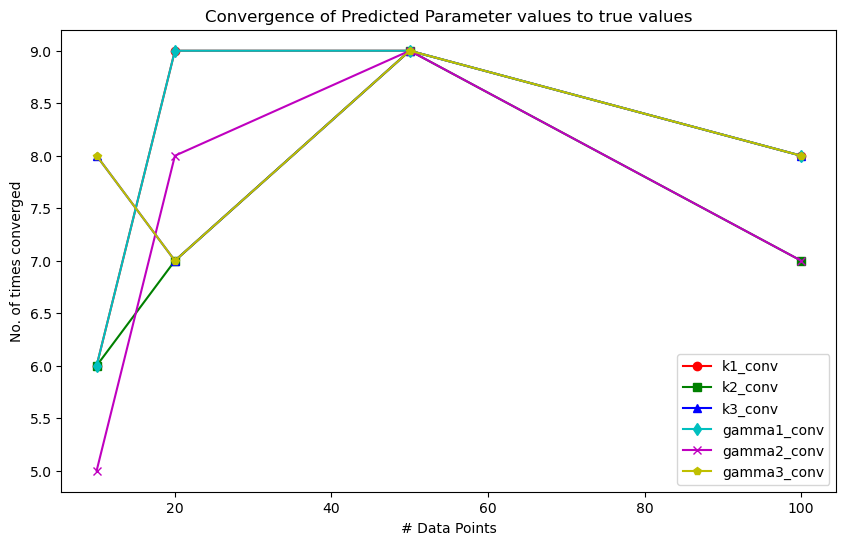

In [23]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(data_points, k1_conv, marker='o', color='r', label='k1_conv')
plt.plot(data_points, k2_conv, marker='s', color='g', label='k2_conv')
plt.plot(data_points, k3_conv, marker='^', color='b', label='k3_conv')
plt.plot(data_points, gamma1_conv, marker='d', color='c', label='gamma1_conv')
plt.plot(data_points, gamma2_conv, marker='x', color='m', label='gamma2_conv')
plt.plot(data_points, gamma3_conv, marker='p', color='y', label='gamma3_conv')

# Adding labels and title
plt.xlabel('# Data Points')
plt.ylabel('No. of times converged')
plt.title('Convergence of Predicted Parameter values to true values')
plt.legend()

plt.savefig("convergence_params.png")

# Display the plot
plt.show()

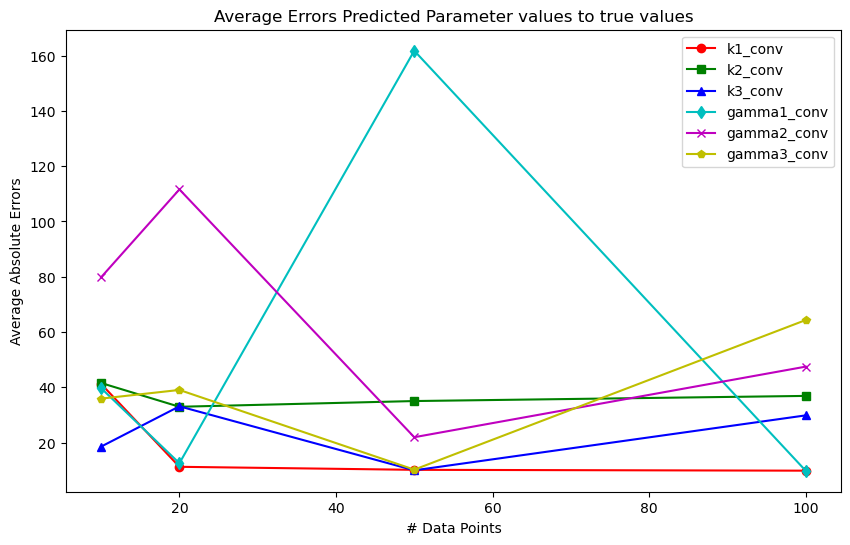

In [22]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(data_points, k1_error, marker='o', color='r', label='k1_conv')
plt.plot(data_points, k2_error, marker='s', color='g', label='k2_conv')
plt.plot(data_points, k3_error, marker='^', color='b', label='k3_conv')
plt.plot(data_points, gamma1_error, marker='d', color='c', label='gamma1_conv')
plt.plot(data_points, gamma2_error, marker='x', color='m', label='gamma2_conv')
plt.plot(data_points, gamma3_error, marker='p', color='y', label='gamma3_conv')

# Adding labels and title
plt.xlabel('# Data Points')
plt.ylabel('% Average Absolute Errors')
plt.title('Average Errors Predicted Parameter values to true values')
plt.legend()

# Display the plot
plt.show()